## This code is to get the correlation between firing rate adaptation and optimal shift

In [15]:
import os
import numpy as np
from scipy.ndimage import convolve1d
import scipy.io as sio
import matplotlib.pyplot as plt
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def plot_head_direction_tuning(ax, angle_data, angle4spike, config, pos_tb=0.01):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """


    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(angle_data, bins=config['hd_bins'], range=(-np.pi, np.pi))
    hd2, _ = np.histogram(angle4spike, bins=config['hd_bins'], range=(-np.pi, np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time
    # #where hd3 is nan, set it to 0
    # hd3 = np.nan_to_num(hd3)
    
    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.nanmax(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(-np.pi, np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    
    #remove yticks
    ax.set_yticks([])
    
    #calculate the preferred direction which corresponds to the peak of the tuning curve
    prefer_hd = theta[np.argmax(hd3_normalized)]
    #add a line to indicate the preferred direction
    ax.plot([prefer_hd, prefer_hd], [0, 1], color='red', linestyle='--', linewidth=1)
    
    return ax, prefer_hd

def get_spikeratio(angle_data, t, spiket, prefer_hd, degreerange=20, timelength=2):
    """
    Calculate adaptation based on periods when head direction (ppoh) is within the preferred range.

    Parameters:
        ppoh (numpy array): Rat head direction (in degrees).
        t (numpy array): Timestamps for ppoh.
        psph: Head direction when a spike occurs.
        pspt: Accurate time when a spike occurs.
        prefer_hd (float): Preferred direction (in radians).
        degreerange (int): Range around the preferred direction to consider (in degrees).

    Returns:
        list: A list of tuples where each tuple contains the start time, end time of a continuous period, 
              and the spike times within that period.
    """
    # Convert angle_data from radians to degrees and wrap it to 0-360
    angle_data = np.rad2deg(angle_data)
    
    # Convert preferred direction from radians to degrees
    preferred_direction = np.rad2deg(prefer_hd)

    # Calculate the wrapped difference between ppoh and preferred_direction
    diff = (angle_data - preferred_direction + 180) % 360 - 180

    # Assign True if the wrapped difference is within the degreerange, else False
    in_range = np.abs(diff) <= degreerange

    # Find the start and end indices of continuous periods using np.diff and np.where
    changes = np.diff(in_range.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0]

    # Handle cases where the first or last period is continuous
    if in_range[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if in_range[-1]:
        end_indices = np.append(end_indices, len(in_range) - 1)

    # Extract spike times within each continuous period
    count = 0
    
    Firsthalf_spikes = []
    Secondhalf_spikes = []
    durs = []
    
    for start, end in zip(start_indices, end_indices):
        start_time = t[start]
        end_time = t[end]
        
        #if end_time - start_time > timelength, rotation is too slow
        if end_time - start_time > timelength or end_time - start_time < 0.01:
            continue #do not consider this period
        
        duration = end_time - start_time
        
        timecut = duration / 2
        
        #consider only those head rotating periods when entering from one side and leaving from the other side
        anglewithinrange = angle_data[start:end]-preferred_direction
        #the sign of the anglewithinrange should be different at the start and end
        
        if anglewithinrange[0] * anglewithinrange[-1] > 0:
            continue
        
        # print(anglewithinrange)
        
        count += 1 
        
        #count the number of spikes between start_time and start_time + timelength/2
        spikes_in_period_firsthalf = len(spiket[(spiket >= start_time) & (spiket <= start_time+timecut)])
        
        #count the number of spikes between start_time + timelength/2 and start_time + timelength
        spikes_in_period_secondhalf = len(spiket[(spiket > end_time - timecut) & (spiket <= end_time)])
 
        # Ensure at least 1 spike exist in both window
        if spikes_in_period_firsthalf + spikes_in_period_secondhalf < 1:
            continue 
    
        # spikeratio_diffsum = (spikes_in_period_firsthalf-spikes_in_period_secondhalf)/(spikes_in_period_firsthalf+spikes_in_period_secondhalf)
        
        Firsthalf_spikes.append(spikes_in_period_firsthalf)
        Secondhalf_spikes.append(spikes_in_period_secondhalf)
        durs.append(duration)

    if np.sum(Firsthalf_spikes)+np.sum(Secondhalf_spikes) == 0:
        spikeratio_diffsum = np.nan
        mean_dur = np.nan
    else:
        spikeratio_diffsum = (np.sum(Firsthalf_spikes)-np.sum(Secondhalf_spikes))/(np.sum(Firsthalf_spikes)+np.sum(Secondhalf_spikes))
        mean_dur = np.mean(durs)
    return spikeratio_diffsum, mean_dur


In [17]:
# all folders in /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5
dataset = 'Dataset_5'
folders = os.listdir('/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset)

adn_optimalshifts = []
adn_spikeratios = []
adn_meandurs = []

for folder in folders:
    
    mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset + '/' + folder + '/Analysis/'
    
    #load anticipation data
    peak_lag  = utils.load_anticipation(mousetrial)
    
    mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset + '/' + folder + '/Data/'
    data = utils.load_data(mousetrial)
    t = data['t']
    angle_data = data['angle_data']
    brainarea = data['adn'] #adn = data['pos']
    hd = data['hd']
    
    spike_times = data['spike_times']
    
    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
    }
    degreerange=20
    timelength=2
    
    #plot all directional tuning
    fig = plt.figure(figsize=(2*len(spike_times),2))
    for i in range(len(spike_times)):
        spike_time_cell_i = spike_times[i]
        spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

        #calculate the head direction angle when spike_array_cell_i is not zero
        angle4spike = angle_data[spike_array_cell_i != 0]

        ax = fig.add_subplot(1,len(spike_times),i+1, polar=True)
        ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

        #calculate firing rate adaptation
        spikeratio, meandur = get_spikeratio(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength)

        if brainarea[i] == 1 and hd[i] == 1: #it is a head direction cell in the target brain area
            adn_optimalshifts.append(peak_lag[i])
            adn_spikeratios.append(spikeratio)
            adn_meandurs.append(meandur)
    
    plt.close()
            
                

97 97 97


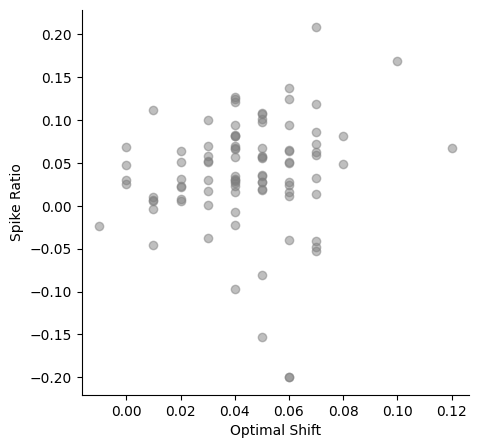

In [18]:
#plot the correlation between spikeratios and optimalshifts asn a scatter plot

print(len(adn_optimalshifts), len(adn_spikeratios), len(adn_meandurs))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(adn_optimalshifts, adn_spikeratios, c='gray', alpha=0.5)
ax.set_xlabel('Optimal Shift')
ax.set_ylabel('Spike Ratio')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## check dataset 1, HDC from PoS

In [5]:
# all folders in /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5
dataset = 'Dataset_1'
folders = os.listdir('/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset)

pos_optimalshifts = []
pos_spikeratios = []
pos_meandurs = []

for folder in folders:
    
    mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset + '/' + folder + '/Analysis/'
    
    #load anticipation data
    peak_lag  = utils.load_anticipation(mousetrial)
    
    mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset + '/' + folder + '/Data/'
    data = utils.load_data(mousetrial)
    t = data['t']
    angle_data = data['angle_data']
    brainarea = data['pos'] #adn = data['pos']
    hd = data['hd']
    
    spike_times = data['spike_times']
    
    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
    }
    degreerange=20
    timelength=2
    
    #plot all directional tuning
    fig = plt.figure(figsize=(2*len(spike_times),2))
    for i in range(len(spike_times)):
        spike_time_cell_i = spike_times[i]
        spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

        #calculate the head direction angle when spike_array_cell_i is not zero
        angle4spike = angle_data[spike_array_cell_i != 0]

        ax = fig.add_subplot(1,len(spike_times),i+1, polar=True)
        ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

        #calculate firing rate adaptation
        spikeratio, meandur = get_spikeratio(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength)

        if brainarea[i] == 1 and hd[i] == 1: #it is a head direction cell in the target brain area
            pos_optimalshifts.append(peak_lag[i])
            pos_spikeratios.append(spikeratio)
            pos_meandurs.append(meandur)
    
    plt.close()
            
                

1062 1062 1062


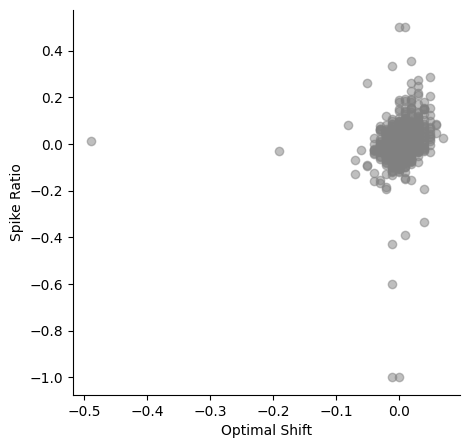

In [6]:
#plot the correlation between spikeratios and optimalshifts asn a scatter plot

print(len(pos_optimalshifts), len(pos_spikeratios), len(pos_meandurs))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(pos_optimalshifts, pos_spikeratios, c='gray', alpha=0.5)
ax.set_xlabel('Optimal Shift')
ax.set_ylabel('Spike Ratio')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

PearsonRResult(statistic=0.12346573008024452, pvalue=0.2383685076902764)
PearsonRResult(statistic=0.17882242130798684, pvalue=6.923433319293274e-09)


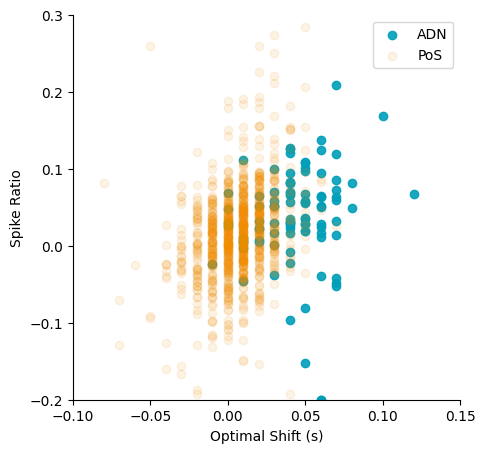

In [14]:
#plot adn_spike_ratio vs adn_optimalshifts, and pos_spike_ratio vs pos_optimalshifts in the same plot with different colors

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

adn_optimalshifts = np.array(adn_optimalshifts)
adn_spikeratios = np.array(adn_spikeratios)
pos_optimalshifts = np.array(pos_optimalshifts)
pos_spikeratios = np.array(pos_spikeratios)

#remove nan values before plotting
is_nan = (np.isnan(adn_spikeratios) | np.isnan(adn_optimalshifts))
adn_optimalshifts = adn_optimalshifts[~is_nan]
adn_spikeratios = adn_spikeratios[~is_nan]

is_nan = (np.isnan(pos_spikeratios) | np.isnan(pos_optimalshifts))
pos_optimalshifts = pos_optimalshifts[~is_nan]
pos_spikeratios = pos_spikeratios[~is_nan]

ax.scatter(adn_optimalshifts, adn_spikeratios, c='#009FB9', alpha=0.9, label='ADN')
ax.scatter(pos_optimalshifts, pos_spikeratios, c='#F18D00', alpha=0.1, label='PoS')

# x = np.linspace(-0.1, 0.15, 100)

# #add linear regression line to the scatter plot
# m, b = np.polyfit(adn_optimalshifts, adn_spikeratios, 1)
# ax.plot(x, m*x + b, color='#009FB9')

# m, b = np.polyfit(pos_optimalshifts, pos_spikeratios, 1)
# ax.plot(x, m*x + b, color='#F18D00')

#print pearsion correlation coefficient and p value
from scipy.stats import pearsonr
print(pearsonr(adn_optimalshifts, adn_spikeratios))
print(pearsonr(pos_optimalshifts, pos_spikeratios))

ax.set_xlim(-0.1, 0.15)
ax.set_ylim(-0.2, 0.3)
ax.legend()
ax.set_xlabel('Optimal Shift')
ax.set_ylabel('Spike Ratio')

ax.set_xlabel('Optimal Shift (s)')
ax.set_ylabel('Spike Ratio')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()


## Check dataset 2, HDC from PoS

In [20]:
# all folders in /home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5
dataset = 'Dataset_2'
folders = os.listdir('/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset)

pos2_optimalshifts = []
pos2_spikeratios = []
pos2_meandurs = []

for folder in folders:
    
    mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset + '/' + folder + '/Analysis/'
    
    #load anticipation data
    peak_lag  = utils.load_anticipation(mousetrial)
    
    mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/' + dataset + '/' + folder + '/Data/'
    data = utils.load_data(mousetrial)
    t = data['t']
    angle_data = data['angle_data']
    brainarea = data['pos'] #adn = data['pos']
    hd = data['hd']
    
    spike_times = data['spike_times']
    
    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
    }
    degreerange=20
    timelength=2
    
    #plot all directional tuning
    fig = plt.figure(figsize=(2*len(spike_times),2))
    for i in range(len(spike_times)):
        spike_time_cell_i = spike_times[i]
        spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

        #calculate the head direction angle when spike_array_cell_i is not zero
        angle4spike = angle_data[spike_array_cell_i != 0]

        ax = fig.add_subplot(1,len(spike_times),i+1, polar=True)
        ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

        #calculate firing rate adaptation
        spikeratio, meandur = get_spikeratio(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength)

        if brainarea[i] == 1 and hd[i] == 1: #it is a head direction cell in the target brain area
            pos2_optimalshifts.append(peak_lag[i])
            pos2_spikeratios.append(spikeratio)
            pos2_meandurs.append(meandur)
    
    plt.close()
            
                


471 471 471


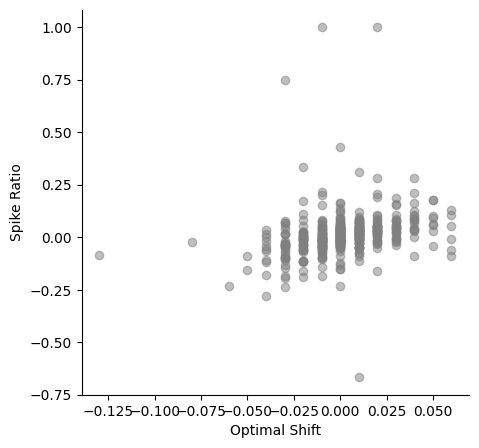

In [21]:
#plot the correlation between spikeratios and optimalshifts asn a scatter plot

print(len(pos2_optimalshifts), len(pos2_spikeratios), len(pos2_meandurs))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(pos2_optimalshifts, pos2_spikeratios, c='gray', alpha=0.5)
ax.set_xlabel('Optimal Shift')
ax.set_ylabel('Spike Ratio')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [79]:
print(np.isnan(adn_optimalshifts).sum(), np.isnan(pos_optimalshifts).sum())
print(len(adn_optimalshifts), len(pos_optimalshifts))


0 0
97 1062


## check one cell

**************************************************
604
spikeratio:  0.16887417218543047 mean duration:  0.5725581395349129


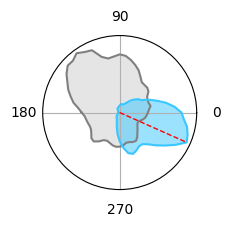

In [41]:
mousetrial = '/home/zilong/Desktop/HDPhasePrecession/DuszkiewiczData/Dataset_5/A1104-180328/Data'

#load data
data = utils.load_data(mousetrial)

t = data['t']
angle_data = data['angle_data']

adn = data['adn']
hd = data['hd']

idx = np.where((adn == 1) & (hd==1))[0]

spike_times = data['spike_times']

spike_times = [spike_times[i] for i in idx]

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
}
degreerange = 20
timelength = 2

#angle4spike
spike_time_cell_i = spike_times[0]
spike_array_cell_i = utils.compute_spike_array(spike_time_cell_i, t)

#calculate the head direction angle when spike_array_cell_i is not zero
angle4spike = angle_data[spike_array_cell_i != 0]

fig = plt.figure(figsize=(2,2))

ax = fig.add_subplot(111, polar=True)
ax, prefer_hd = plot_head_direction_tuning(ax, angle_data, angle4spike, config)

#caulcate firing rate adaptation 
spikeratio, dur = get_spikeratio(angle_data, t, spike_time_cell_i, prefer_hd, degreerange=degreerange, timelength=timelength)

print('spikeratio: ', spikeratio, 'mean duration: ', dur)